# Project 2: Exploring the GitHub Dataset with Colaboratory
---


In this project, you will explore one of BigQuery's public datasets on GitHub and learn to make visualizations in order to answer your questions. This project is due on **Sunday, October 22nd, 08:59PM**. It is worth 50 points, for 15% of your overall grade. After completing this project, make sure to follow the submission instructions in the handout to submit on Gradescope.


### Notes (read carefully!):

* Be sure you read the instructions on each cell and understand what it is doing before running it.
* Don't forget that if you can always re-download the starter notebook from the course website if you need to.
* You may create new cells to use for testing, debugging, exploring, etc., and this is in fact encouraged! Just make sure that the final answer for each question is **in its own cell** and **clearly indicated**.
* Colab will not warn you about how many bytes your SQL query will consume.  **Be sure to check on the BigQuery UI first before running queries here!**
* See the assignment handout for submission instructions.
* Have fun!

## Collaborators:
Please list the names and Registration number of your collaborators below:
* *Name, Registration number*

# Overview

BigQuery has a massive dataset of GitHub files and statistics, including information about repositories, commits, and file contents.  In this project, we will be working with this dataset. Don't worry if you are not too familiar with Git and GitHub -- we will explain everything you need to know to complete this part of the assignment.

---
## Notes

**The GitHub dataset available on BigQuery is actually quite massive. *A single query on the "contents" table alone (it is 2.16TB!) can eat up your 1TB allowance for the month AND cut into about 10% of your GCloud credit for the class.***

To make this part of the project more manageable, we have subset the original data.  We have preserved almost all information in the original tables, but we kept only the information on the top 500,000 most "watched" GitHub repos between January 2016 and October 2018.

You can see the tables we will be working with [here](https://console.cloud.google.com/bigquery?project=cs145-fa21-326819&authuser=1&p=cs145-fa21-326819&d=project2&page=dataset). **Read through the schemas to get familiar with the data**.  Note that some of the tables are still quite large (the contents table is about 500GB), so you should exercise the usual caution when working with them.  Before running queries on this notebook, it's good practice to first set up query limits on your BigQuery account or see how many bytes will be billed on the web UI.

---

## *Make sure to use our subsetted dataset, not the original BigQuery dataset!*





## A Super Quick Primer on Git

If you are not very familiar with Git and GitHub, here are some high-level explanations that will give you enough context to get you through this part of the problem:

*  *GitHub*: GitHub is a source-control service provider.  GitHub allows you to collaborate on and keep track of source code in a fairly efficient way.

*  *commit*: A commit can be thought of as a change that is applied to some set of files. i.e., if some set of files is in some state A, you can make changes to A and *commit* your changes to the set of files so that it is now in state B.  A commit is identified by a *hash* of the information in your change (the author of the commit, who actually committed [i.e. applied] the changes to the set of files, the changes themselves, etc.)

* *parent commit*: The commit that came before your current commit.

*   *repo*:  A repo (short for repository) is GitHub's abstraction for a collection of files along with a history of commits on those files. If you have GitHub username "foo" and you make a repository called "data-rocks", your repo name will be "foo/data-rocks".  You can think of a repo's history in terms of its commits.  E.g., "foo/data-rocks" can have the set of "states" A->B->C->D, where each state change (A->B, B->C, C->D) was due to a commit.

*   *branch*:  To keep track of different commit histories, GitHub repos can have branches.  The 'main' branch (i.e. commit history) of the repo is called the 'master' branch.  Say on "foo/data-rocks" we have the commit history A->B->C->D on the master branch.  If someone else comes along and decides to add a cool new feature to "foo/data-rocks", they can create a branch called "cool-new-feature" that branches away from the master branch. All the code from the main branch will be there, but new code added to "cool-new-feature" will not be on the main branch.

*   *ref*: For the purpose of this assignment, you can think of the 'ref' field on the "files" table as referring to the branch in which a file lives in a repository at some point in time.



For the purposes of this question, you don't need to know about the following things in detail:


*   Commit trees
*   The encoding attribute on the commits table

If you want more clarifications about Git and GitHub in order to answer this question, be sure to post on Ed or come to Office Hours.  In many cases, a quick web search will also help answer your question.

# Section 1 | Understanding the Dataset (4 points)

---

Things to note:
* A file ID changes based on a file's contents; it is not assigned at a file's creation.
* Different repos can have files with the same paths.
* It is possible to have separate files with identical contents.
* A repo may have one file across multiple branches.



## Question 1: Schema Comprehension (4 points)

Each of the following parts is worth 1 point.



### a)  What is the primary key of `github_repo_files`? (1 point)

--- Primary key is: irepo_name

### b) What is the primary key in `github_repo_licenses`? What is the foreign key? (1 point)

--- Primary key is: license


--- Foreign key is: Irepo_name




### c) If we were given authors and we wanted to know what programming languages they used in the repos that they contributed to, which tables should we use? (1 point)

--- bigquery-public-data.github_repo_languages


--- bigquery-public-data.github_repo_commits






### d) If we wanted to know whether using different licenses had an effect on a repo's watch count, which tables would we use? (1 point)

--- bigquery-public-data.github_repo_licenses

--- bigquery-public-data.githun_sample_repos

# Section 2 | Query Performance (8 points)
---


In this section, we'll look at some inefficient queries and think about how we can make them more efficient. For this section, we'll consider efficiency in terms of how many bytes are processed.

## Question 2: Optimizing Queries (8 points)


For the next three subquestions, consider the following query:

```
SELECT DISTINCT author.name
FROM `cs145-fa21-326819.project2.github_repo_commits` commits_1
WHERE (SELECT COUNT(*)
       FROM `cs145-fa21-326819.project2.github_repo_commits` commits_2
       WHERE commits_1.author.name = commits_2.author.name) > 20

```

**NOTE:** We do **NOT** recommend running this unoptimized query in BigQuery, as it will run for a very long time (over 15 minutes if not longer). However, feel free to run an optimized version of this query after finishing part (c), which takes about 5 seconds to run.

### a) In one to two sentences, explain what this query does. (1 point)

--- This query first takes the distinct author names from the table bigquery-public-data.github_repo_commits if the count of occurrences of each author's name in the same table is greater than 20. It finds the authors who have made more than 20 commits.

###b) Briefly explain why this query is inefficient (in terms of bytes that need to be processed) and how it can be improved to be more efficient. (1 point)

--- This query is inefficient because for each record in outer loop, one iteration over the entire table is required, and resulting in a high number of query executions and processing a large number of bytes. To improve this, we need to avoid the iteration over the entire table for each record. In that case, we use 'GROUP BY' and 'HAVING' clauses to improve efficiency in terms of processing bytes.

###c) Following from part (b), write a more efficient version of the query. (2 points)

--- SELECT author.name
--- FROM `cs145-fa19.project2.github_repo_commits`
--- GROUP BY author.name
--- HAVING COUNT (*)>20










For the next three subquestions, consider the following query:

```
SELECT id
FROM (
  SELECT files.id, files.mode, contents.size
  FROM
    `cs145-fa21-326819.project2.github_repo_files` files,
    `cs145-fa21-326819.project2.github_repo_readme_contents` contents
  WHERE files.id = contents.id
  )
WHERE mode = 33188 AND size > 1000  
LIMIT 10
```


###d) Briefly explain why this query is inefficient (in terms of bytes that need to be processed) without the query optimization and how it can be improved to be more efficient. (1 point)

--- It is inefficient because it has too many reads and writes from two 'FROM' clauses. It can be improved by using an 'INNER JOIN' to combine two tables and then set the constraint by using 'WHERE'.

---

###e) Following from part (d), write a more efficient version of the query. (2 points)

Hint: Think about the number of bytes processed by the unoptimized query. Can any operator be moved around to reduce this number?

--- SELECT contents.id
--- FROM `cs145-fa19.project2.github_repo_files` files INNER JOIN
          `cs145-fa19.project2.github_repo_readme_contents` contents
--- ON files.id=contents.id
--- WHERE mode=33188 AND size > 1000
--- LIMIT 10

###f) Run both the original query and your optimized query on BigQuery and pay attention to the number of bytes processed. How do they compare, and is it what you expect? Explain why this is happening in a few sentences. (1 point)

Hint: Look at the query plan under "Execution details" in the bottom panel of BigQuery. It may be especially helpful to look at stage "S00: Input".

--- The average time for reads and writes of the original query is 117ms and 10ms respectively
--- The average time for optimized read and writes is 28ms and 5ms respectively
--- Bytes shuffled in both the cases is 6.48MB
--- It is concluded that the original is slower.

To learn more about writing efficient SQL queries and how BigQuery optimizes queries, check out [Optimizing query computation](https://cloud.google.com/bigquery/docs/best-practices-performance-compute) and [Query plan and timeline](https://cloud.google.com/bigquery/query-plan-explanation).

# Section 3: Visualizing the Dataset (38 points)
---


In this section, you'll be answering questions about the dataset, similar to the first project. The difference is that instead of answering with a query, you will be answering with a visualization. Part of this assignment is for you to think about which data (specifically, which indicators) you should be using in order to answer a particular question, and about what type of chart / picture / visualization you should use to clearly convey your answer.

## General Instructions
* For each question, you will have at least two cells - a SQL cell where you run your query (and save the output to a data frame), and a visualization cell, where you construct your chart. For this project, make sure that **all data manipulation is to be done in SQL**. Please do not modify your data output using `pandas` or some other data library. Python should only be used for data visualization.
* Please make all charts clear and readable - this includes adding axes labels, clear tick marks, clear point markers / lines / color schemes (i.e. don't repeat colors across categories), legends, and so on.

## Setting up BigQuery and Dependencies

Run the cell below (shift + enter) to authenticate your project.

Note that you need to fill in the `project_id` variable with the Google Cloud project id you are using for this course.  You can see your project ID by going to https://console.cloud.google.com/cloud-resource-manager

In [4]:
# Run this cell to authenticate yourself to BigQuery.
from google.colab import auth
auth.authenticate_user()
project_id = 'db-project-2-401218'
from google.cloud import bigquery

## Visualization

For this project, we will be officially supporting the use of matplotlib (https://matplotlib.org/3.0.0/tutorials/index.html), but feel free to use another graphing library if you are more comfortable with it (eg. plotly, seaborn).

If you are not familiar with matplotlib, please reference [this](https://matplotlib.org/3.0.0/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) tutorial to get started.

In [ ]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt


%matplotlib inline
import pandas as pd

### How to Use BigQuery and visualize in Colab

Jupyter notebooks (what Colab notebooks are based on) have a concept called "magics".
If you write the following line at the top of a `Code` cell:


```
%%bigquery --project $project_id variable # this is the key line
SELECT ....
FROM ...
```

That "%%" converts the cell into a SQL cell. The resulting table that is generated is saved into `variable`.

Then in a second cell, use the library of your choice to plot the variable. Here is an example using matplotlib:

```python
plt.figure()
plt.scatter(variable["x"], variable["y"])
plt.title("Plot Title")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
```

## Question 3: A First Look at Repo Features (6 points)


Let's get our feet wet with this data by creating the following plots:

1.   Language distribution across repos
2.   File size distribution
3.   The distribution of the length of commit messages


Note that you will not receive full credit if your charts are  poorly made (i.e. very unclear or unreadable).


### Hints
* Some of these plots will need at least one of their axes to be log-scaled in order to be readable
* For more readable plots, you can use [pandas.DataFrame.sample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html).  A sample size between 1,000 and 10,000 should give you more readable plots.
* Recommended Graph Types: bar chart or scatter plot.

##  Reminders
* Be careful with your queries!  Don't run `SELECT *` blindly on a table in this Colab notebook since you will not get a warning of how much data the query will consume.  Always how much data a query will consume on the BigQuery UI first -- you are also better off setting a query limit as we described earlier.
* Don't forget to use the subsetted GitHub tables we provide [here](https://console.cloud.google.com/bigquery?project=cs145-fa21-326819&authuser=1&p=cs145-fa21-326819&d=project2&page=dataset), not the original ones on BigQuery.




### a) Language distribution (2 points)
#### (x-axis: programming language, y-axis: # repos containing at least one file in that language)

To keep the chart readable, only keep the top 20 languages.

**Hint:** https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays (Lookup keyword UNNEST)


In [5]:
%%bigquery --project db-project-2-401218

SELECT l.name as Lang_name, COUNT(grl.lrepo_name) as repo_count
FROM `cs145-fa21-326819.project2.github_repo_languages` as grl, UNNEST(grl.language) as l
WHERE l.bytes > 0
GROUP BY l.name
ORDER BY repo_count DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

,Lang_name,repo_count
0,JavaScript,60429
1,Shell,45235
2,HTML,42574
3,Python,36698
4,CSS,35442
5,Makefile,22454
6,Java,21377
7,Ruby,19881
8,C,19390
9,C++,17522


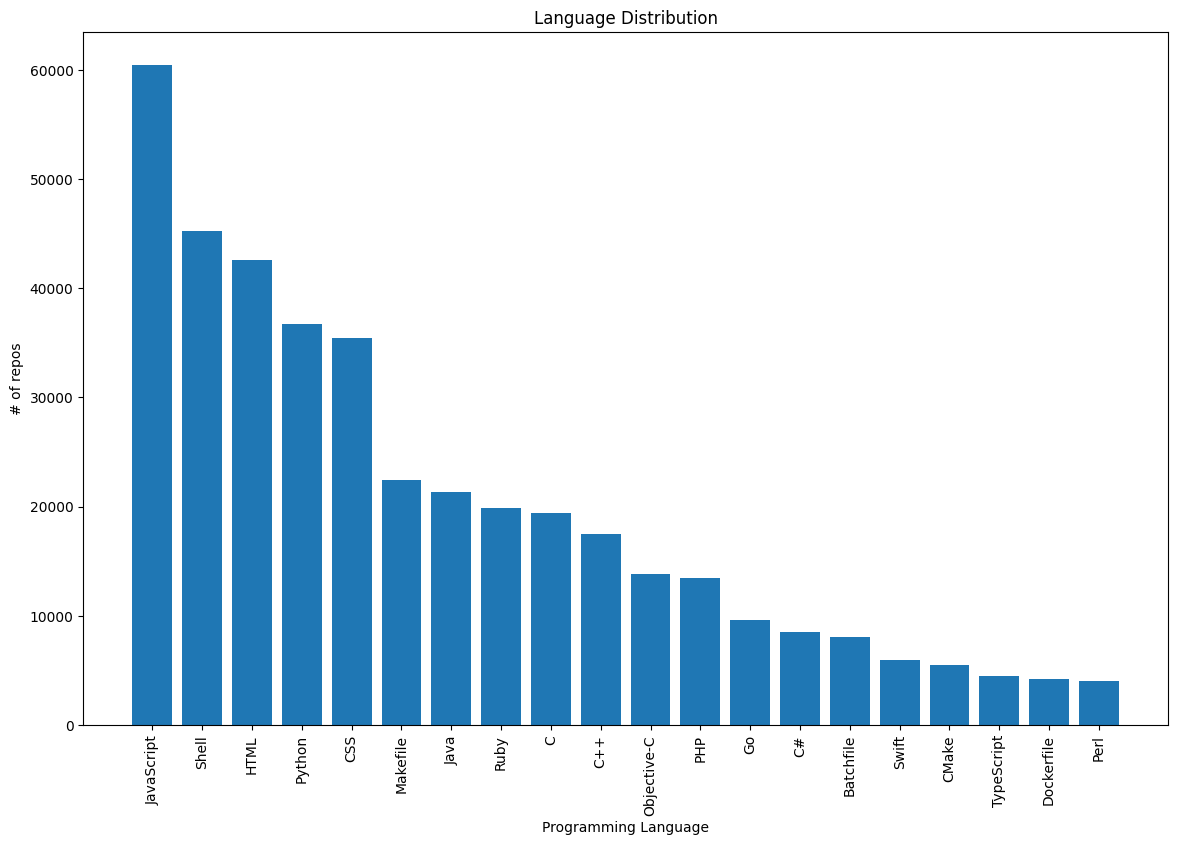

In [ ]:
# YOUR PLOT CODE HERE
from google.cloud import bigquery

# Authenticate and create a BigQuery client
client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT l.name as Lang_name, COUNT(grl.lrepo_name) as repo_count
FROM `cs145-fa21-326819.project2.github_repo_languages` as grl, UNNEST(grl.language) as l
WHERE l.bytes > 0
GROUP BY l.name
ORDER BY repo_count DESC
LIMIT 20
"""

# Execute the query and store the results in a DataFrame
results = client.query(query).to_dataframe()

# Now, you can create the bar chart using results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 9))
plt.bar(results['Lang_name'], results['repo_count'])
plt.title("Language Distribution")
plt.xlabel("Programming Language")
plt.xticks(rotation=90)
plt.ylabel("# of repos")
plt.show()


### b) File size distribution (2 points)
#### (x-axis: file size, y-axis: # files of that size)

In [6]:
%%bigquery --project db-project-2-401218

# YOUR QUERY HERE
SELECT  COUNT(grc.id), grc.size
FROM `cs145-fa21-326819.project2.github_repo_contents` as grc
GROUP BY grc.size

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,size
0,9064,1772
1,24466,438
2,1325,6562
3,23626,454
4,1739,7047
...,...,...
706781,16,134988
706782,16,114786
706783,16,83514
706784,16,166092


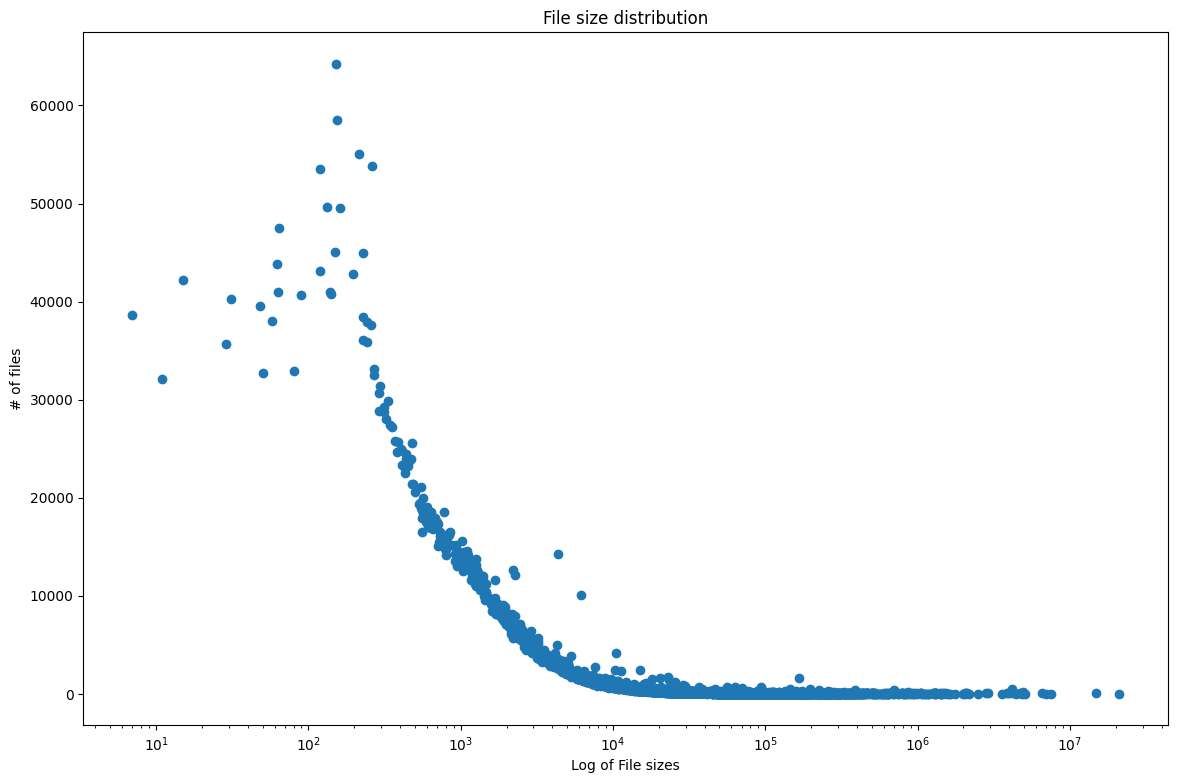

In [ ]:
# YOUR PLOT CODE HERE
from google.cloud import bigquery

# Authenticate and create a BigQuery client
client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT  COUNT(grc.id), grc.size
FROM `cs145-fa21-326819.project2.github_repo_contents` as grc
GROUP BY grc.size
"""

# Execute the query and store the results in a DataFrame
results = client.query(query).to_dataframe()

# Now, you can create the bar chart using results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 9))
plt.scatter(results['size'][:10000], results['f0_'][:10000])
plt.title("File size distribution")
plt.xlabel("Log of File sizes")
# plt.xticks(rotation=90)
plt.ylabel("# of files")
plt.xscale('log')
plt.show()

### c) The distribution of the length of commit messages (2 points)
#### (x-axis: length of the commit message, y-axis: # commits with that length)

**Note**: The query for this plot may use ~30GB of data.

In [7]:
%%bigquery --project db-project-2-401218

# YOUR QUERY HERE
SELECT COUNT(grc.commit) as commit_count, LENGTH(grc.message) as commit_length
FROM `cs145-fa21-326819.project2.github_repo_commits` as grc
GROUP BY LENGTH(grc.message)
LIMIT 10000

Query is running:   0%|          |

Downloading:   0%|          |

,commit_count,commit_length
0,28729,633
1,530932,64
2,107668,223
3,794,2080
4,113800,158
...,...,...
9995,1,157068
9996,2,5391
9997,6,17050
9998,1,13114


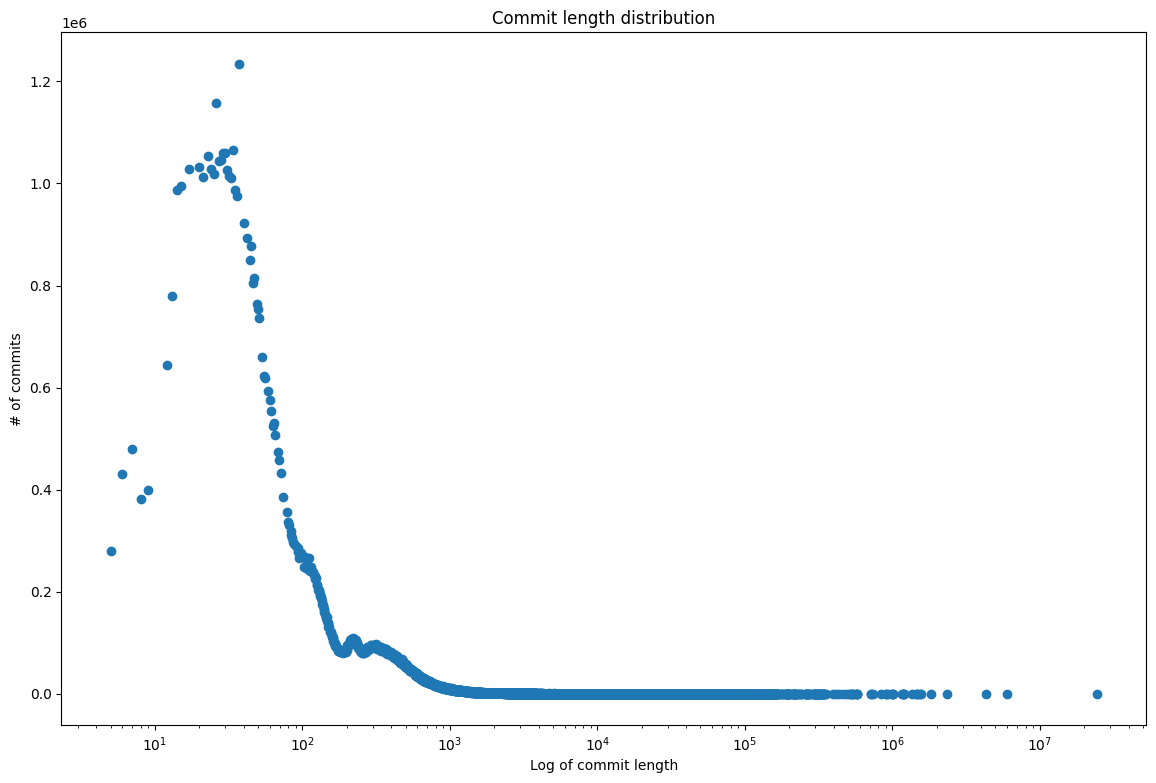

In [ ]:
# YOUR PLOT CODE HERE
from google.cloud import bigquery

# Authenticate and create a BigQuery client
client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT COUNT(grc.commit) as commit_count, LENGTH(grc.message) as commit_length
FROM `cs145-fa21-326819.project2.github_repo_commits` as grc
GROUP BY LENGTH(grc.message)
LIMIT 10000
"""

# Execute the query and store the results in a DataFrame
results = client.query(query).to_dataframe()

# Now, you can create the bar chart using results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 9))
plt.scatter(results['commit_length'], results['commit_count'])
plt.title("Commit length distribution")
plt.xlabel("Log of commit length")
# plt.xticks(rotation=90)
plt.ylabel("# of commits")
plt.xscale('log')
plt.show()

## What Makes a Good Repo?
Given that we have some interesting data at our disposal, let's try to answer the question: what makes a good GitHub repo? For our purposes, a "good" repo is simply a repo with a high watch count; this refers to how many people are following the repo for updates.

To begin, let's see if any of the features we've already explored give us any good answers.

## Question 4: Using What We've Worked With (17 points)

Create plots for the following features in a repo and how they relate to that repo's watch count:

1.  Languages used
2.  Average file size in a repo
3.  Average message length of commits in a repo

### Hints
* Recommended Graph Types: bar chart or scatter plot.


### a) Languages used (4 points)

As in Q3a, please only keep the top 20 languages to keep the chart readable.

In [8]:
%%bigquery --project db-project-2-401218

# YOUR QUERY HERE
SELECT l.name as Lang_name, SUM(gr.watch_count) as watch_count
FROM `cs145-fa21-326819.project2.github_repo_languages` as grl, UNNEST(grl.language) as l
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON grl.lrepo_name = gr.lrepo_name
WHERE l.bytes > 0
GROUP BY l.name
ORDER BY watch_count DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

,Lang_name,watch_count
0,JavaScript,16727771
1,Shell,13714911
2,HTML,12924481
3,CSS,10609932
4,Python,8332562
5,Makefile,6199815
6,Java,5739646
7,Ruby,5236076
8,C,4363857
9,Objective-C,3875394


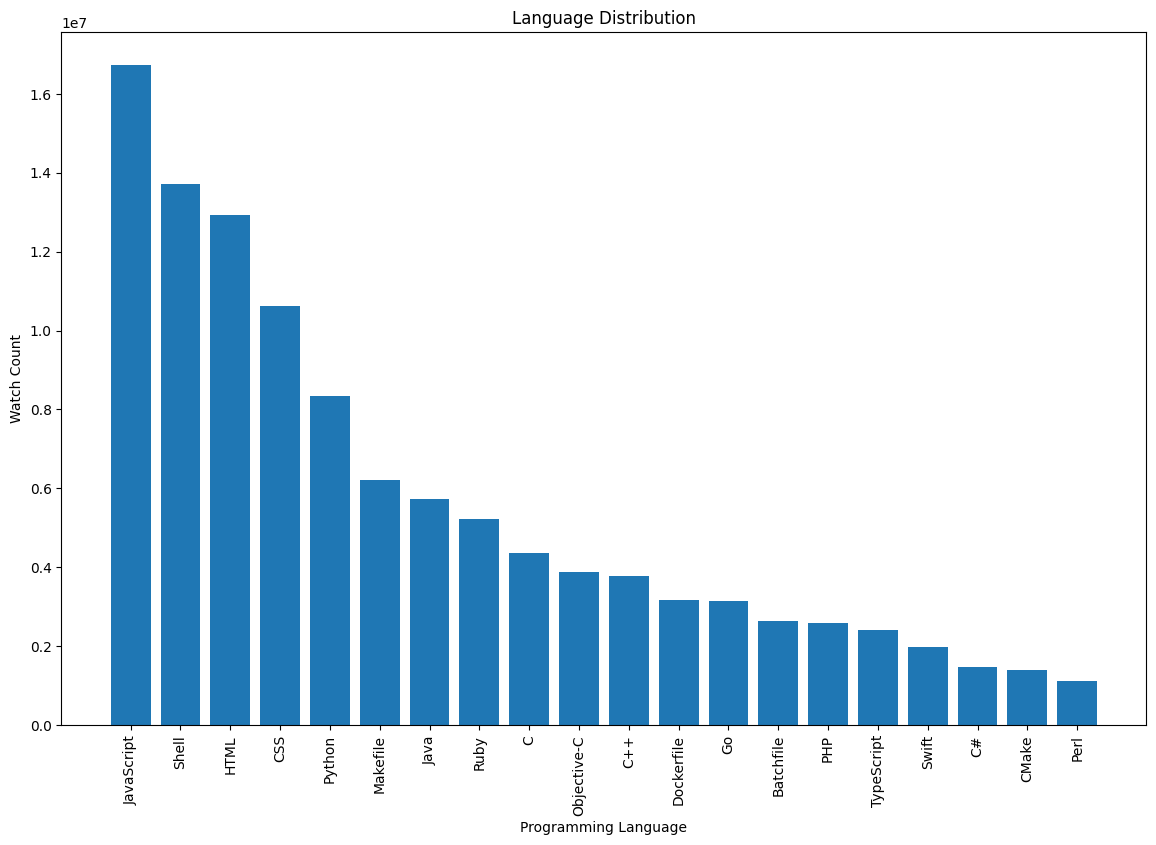

In [ ]:
# YOUR PLOT CODE HERE
from google.cloud import bigquery

# Authenticate and create a BigQuery client
client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT l.name as Lang_name, SUM(gr.watch_count) as watch_count
FROM `cs145-fa21-326819.project2.github_repo_languages` as grl, UNNEST(grl.language) as l
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON grl.lrepo_name = gr.lrepo_name
WHERE l.bytes > 0
GROUP BY l.name
ORDER BY watch_count DESC
LIMIT 20
"""

# Execute the query and store the results in a DataFrame
results = client.query(query).to_dataframe()

# Now, you can create the bar chart using results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 9))
plt.bar(results['Lang_name'], results['watch_count'])
plt.title("Language Distribution")
plt.xlabel("Programming Language")
plt.xticks(rotation=90)
plt.ylabel("Watch Count")
plt.show()

### b) Average file size in a repo (4 points)
**Note:** For this question, you may use the `github_repo_readme_contents` table instead of the full contents table.


In [9]:
%%bigquery --project db-project-2-401218

# YOUR QUERY HERE
SELECT SUM(gr.watch_count) as watch_count, AVG(grrc.size) as size
FROM `cs145-fa21-326819.project2.github_repo_readme_contents` as grrc
INNER JOIN `cs145-fa21-326819.project2.github_repo_files` as grf
ON grrc.id = grf.id
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON gr.lrepo_name = grf.lrepo_name
GROUP BY gr.lrepo_name

Query is running:   0%|          |

Downloading:   0%|          |

,watch_count,size
0,5520936,5.187997
1,13248,1611.940821
2,91,3466.000000
3,4464,10.069444
4,494,1660.269231
...,...,...
174853,72,5342.000000
174854,72,4388.000000
174855,72,2312.000000
174856,72,3225.000000


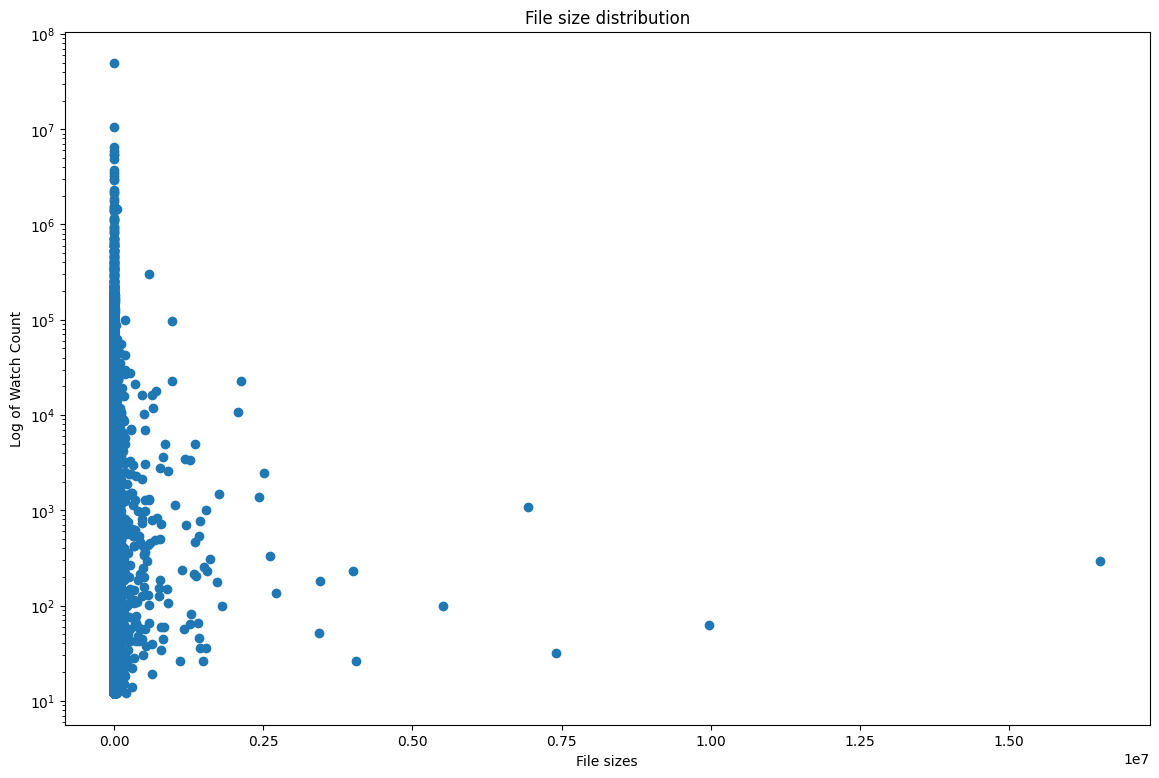

In [ ]:
# YOUR PLOT CODE HERE
from google.cloud import bigquery

# Authenticate and create a BigQuery client
client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT SUM(gr.watch_count) as watch_count, AVG(grrc.size) as size
FROM `cs145-fa21-326819.project2.github_repo_readme_contents` as grrc
INNER JOIN `cs145-fa21-326819.project2.github_repo_files` as grf
ON grrc.id = grf.id
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON gr.lrepo_name = grf.lrepo_name
GROUP BY gr.lrepo_name
"""

# Execute the query and store the results in a DataFrame
results = client.query(query).to_dataframe()

# Now, you can create the bar chart using results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 9))
plt.scatter(results['size'], results['watch_count'])
plt.title("File size distribution")
plt.xlabel("File sizes")
# plt.xticks(rotation=90)
plt.ylabel("Log of Watch Count")
plt.yscale('log')
plt.show()

### c) Average message length of commits on a repo. (6 points)

First, make a plot of the average commit message length of repositories against the number of repositories with that average commit message length.

Then, make a plot of how average commit message length of a repository correlates to its watch count. Round the average commit message length to the nearest integer.


In [11]:
%%bigquery q4c_avg_commit_length_count --project db-project-2-401218

# YOUR QUERY HERE
SELECT COUNT(grc2.lrepo_name) as num_repos, LENGTH(grc2.message) as commit_length
FROM `cs145-fa21-326819.project2.github_repo_commits` as grc2
WHERE LENGTH(grc2.message) IN
    (SELECT ROUND(AVG(LENGTH(grc.message)), 0) as avg_length
    FROM `cs145-fa21-326819.project2.github_repo_commits` as grc
    GROUP BY grc.lrepo_name)
GROUP BY commit_length

Query is running:   0%|          |

Downloading:   0%|          |

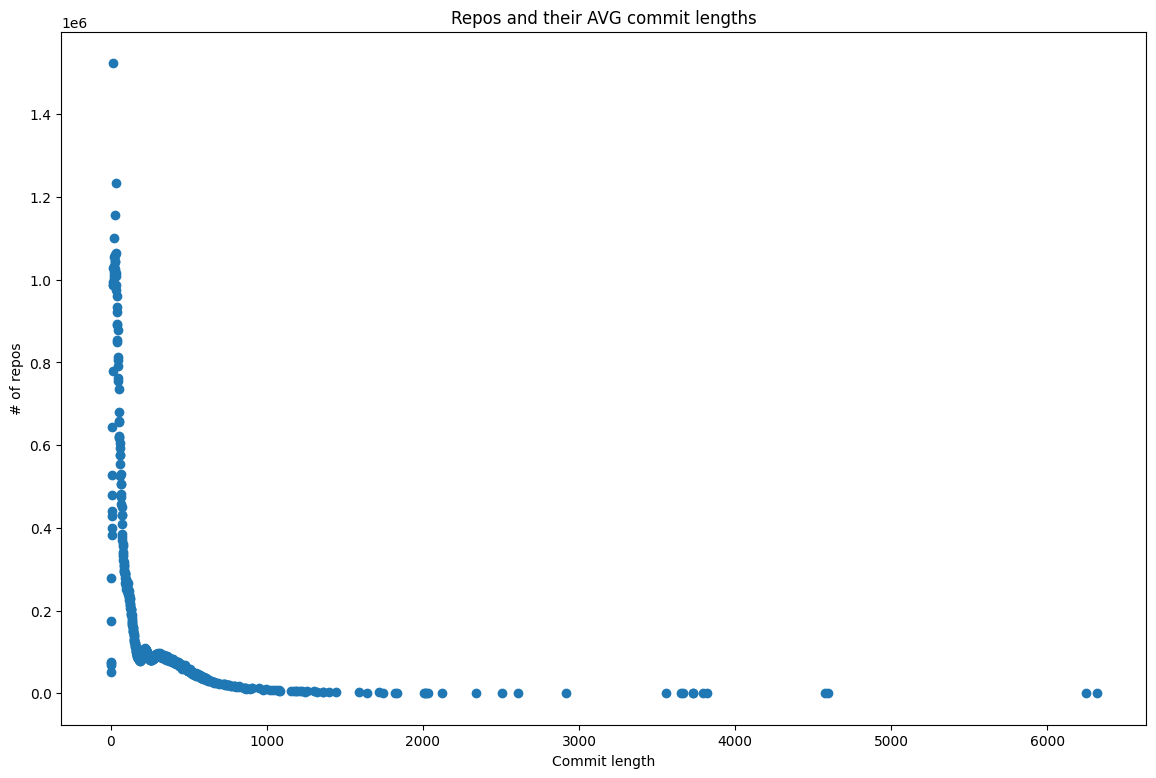

In [ ]:
# YOUR PLOT CODE HERE
q4c_avg_commit_length_count
plt.figure(figsize=(14, 9))
plt.scatter(q4c_avg_commit_length_count['commit_length'], q4c_avg_commit_length_count['num_repos'])
plt.title("Repos and their AVG commit lengths")
plt.xlabel("Commit length")
# plt.xticks(rotation=90)
plt.ylabel("# of repos")
# plt.yscale('log')
plt.show()

In [12]:
%%bigquery q4c_msg_length_watch_count --project db-project-2-401218

# YOUR QUERY HERE
SELECT SUM(gr.watch_count) as watch_count, LENGTH(grc2.message) as commit_length
FROM `cs145-fa21-326819.project2.github_repo_commits` as grc2
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON gr.lrepo_name = grc2.lrepo_name
WHERE LENGTH(grc2.message) IN
    (SELECT ROUND(AVG(LENGTH(grc.message)), 0) as avg_length
    FROM `cs145-fa21-326819.project2.github_repo_commits` as grc
    GROUP BY grc.lrepo_name)
GROUP BY commit_length

Query is running:   0%|          |

Downloading:   0%|          |

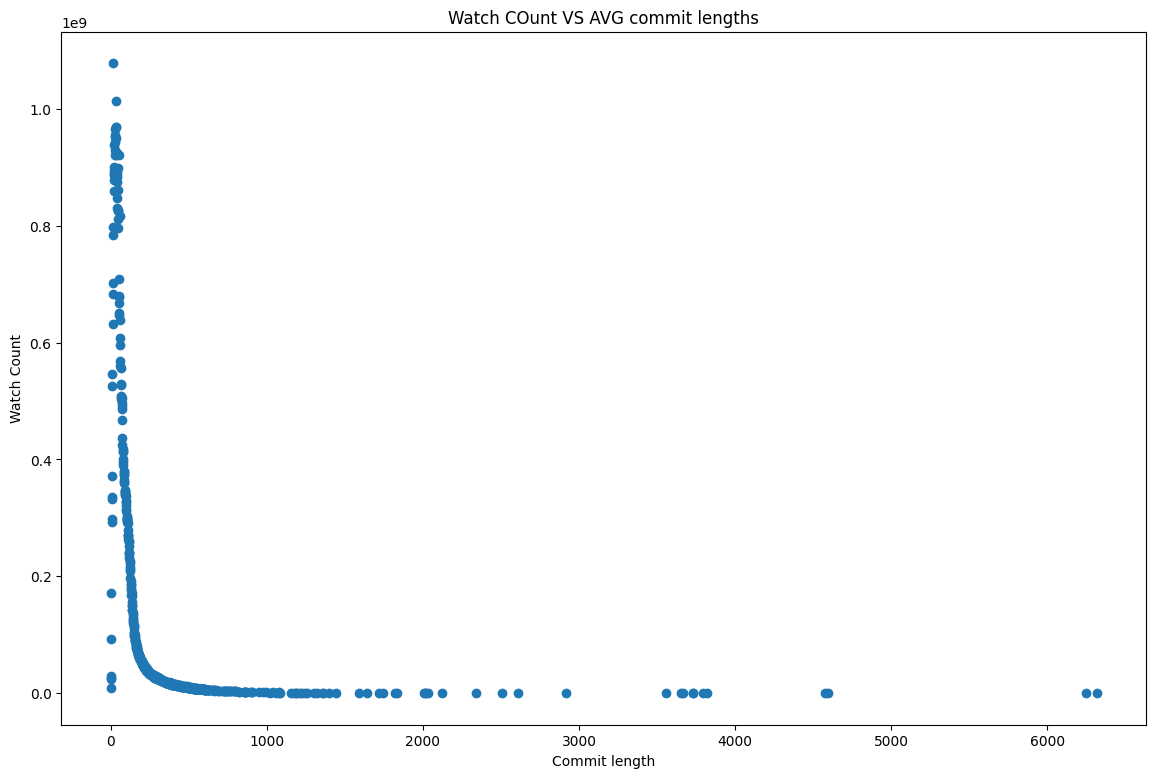

In [ ]:
# YOUR PLOT CODE HERE
q4c_msg_length_watch_count
plt.figure(figsize=(14, 9))
plt.scatter(q4c_msg_length_watch_count['commit_length'], q4c_msg_length_watch_count['watch_count'])
plt.title("Watch COunt VS AVG commit lengths")
plt.xlabel("Commit length")
# plt.xticks(rotation=90)
plt.ylabel("Watch Count")
# plt.yscale('log')
plt.show()

### d) Which, if any, of the features we inspected above have a high correlation to a repo having a high watch count? Does the answer make sense, or does it seem counterintuitive? Explain your answer in a small paragraph, no more than 200 words.  Be sure to cite the charts you generated. (3 points)

---
Languages and commit lengths show a high correlation to a high watch count. It makes sense to include commit lengths as people like to have a concise and to the point description of the work that is done on the commit. Popular languages are used everywhere so if we are not including a popular language, not many people are going to be interested in it.

---

## What Do Others Have to Say?

At this point we have learned a couple of things about how certain features may or may not impact the popularity of a GitHub repo.  However, we really only looked at features of GitHub repos that we had initially explored when we were getting a feel for the dataset!  There has got to be more things we can inspect than that.

If you do a web search for "how to make my git repo popular," you will find that more than a couple of people suggest investing time in your `README` file.  The `README` usually gives an overview to a GitHub project and may include other information about the codebase such as whether its most recent build passed or how to begin contributing to that repo.  [Here](https://github.com/vuejs/vue/blob/dev/README.md) is an example `README` file for the popular web development framework Vue.js.


## IMPORTANT: Note about Contents Table

Note that the original `github_repo_contents` table is about half a TB!  In order to save you the pain of using up 500GB of your credits to subset this table into a workable size for this problem, we have done it for you.

## ***For the rest of this question, be sure that you use the `github_repo_readme_contents` table ***

## Question 5: Analyzing README Features (15 points)

Analyze the following features of a repo's `README` file and how they relate to the watch count of a repository, generating an informative plot for each feature:

1.   Having or not having a `README` file
2.   The length of the `README` file

Consider a `README` file to be any file with the path beginning with "README", not case-sensitive.

You may ignore README files with length 0.

### a) Having or not having a `README` file (6 points)

**Note**: Exclude all empty repos.


In [13]:
%%bigquery --project db-project-2-401218
SELECT table3.watch_count,
    CASE
        WHEN table3.lrepo_name IN (SELECT table1.lrepo_name
                            FROM `cs145-fa21-326819.project2.github_repo_files` as table1
                            INNER JOIN `cs145-fa21-326819.project2.github_repo_readme_contents` as table2
                            ON table1.id = table2.id
                            WHERE table2.size > 0
                            GROUP BY table1.lrepo_name
                            )
        THEN 1
        ELSE 0
    END as have_readme
FROM `cs145-fa21-326819.project2.github_repos` as table3 LIMIT 2000

Query is running:   0%|          |

Downloading:   0%|          |

,watch_count,have_readme
0,291503,1
1,119634,1
2,107721,1
3,92644,1
4,73781,0
...,...,...
1995,4336,1
1996,4334,1
1997,4330,0
1998,4330,1


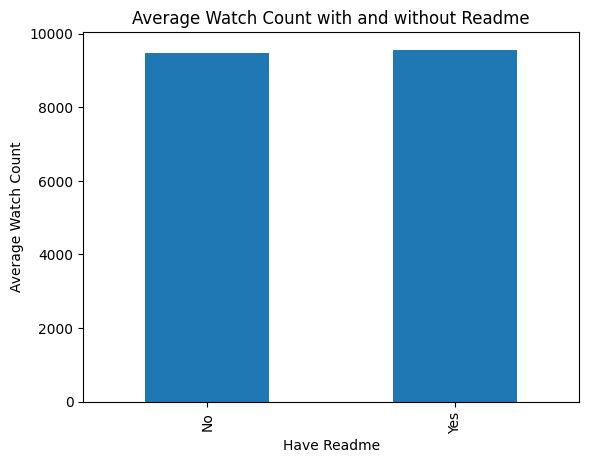

In [ ]:
# YOUR PLOT CODE HERE
client = bigquery.Client(project=project_id)
results = client.query(query).to_dataframe()
# a bar plot of the average watch count for repositories with and without readme files
average_watch_count = results.groupby('have_readme')['watch_count'].mean()
average_watch_count.plot(kind='bar')
plt.title("Average Watch Count with and without Readme")
plt.xlabel("Have Readme")
plt.ylabel("Average Watch Count")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

### b) The length of the `README` file (6 points)

**Note**: If a project has multiple `README` files, you can just take the average length of those files. Ignore repos without `README` files.

In [14]:
%%bigquery --project db-project-2-401218
SELECT AVG(LENGTH(grrc.content)) as length_of_readme, gr.watch_count
FROM `cs145-fa21-326819.project2.github_repo_files` as grf
INNER JOIN `cs145-fa21-326819.project2.github_repo_readme_contents` as grrc
ON grf.id = grrc.id
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON gr.lrepo_name = grf.lrepo_name
GROUP BY gr.lrepo_name, gr.watch_count
HAVING length_of_readme > 0 LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

,length_of_readme,watch_count
0,1899.000000,13
1,874.000000,20
2,338.166667,18
3,3151.000000,34
4,9671.000000,18
...,...,...
995,16673.000000,52
996,16302.000000,26
997,279.000000,20
998,3119.000000,18


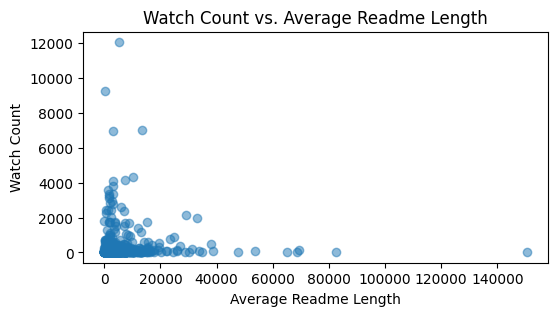

In [ ]:
# YOUR PLOT CODE HERE
client = bigquery.Client(project=project_id)
query = """
SELECT AVG(LENGTH(grrc.content)) as length_of_readme, gr.watch_count
FROM `cs145-fa21-326819.project2.github_repo_files` as grf
INNER JOIN `cs145-fa21-326819.project2.github_repo_readme_contents` as grrc
ON grf.id = grrc.id
INNER JOIN `cs145-fa21-326819.project2.github_repos` as gr
ON gr.lrepo_name = grf.lrepo_name
GROUP BY gr.lrepo_name, gr.watch_count
HAVING length_of_readme > 0
LIMIT 1000
"""

results = client.query(query).to_dataframe()

# Create a scatter plot
plt.figure(figsize=(6, 3))
plt.scatter(results['length_of_readme'], results['watch_count'], alpha=0.5)
plt.title("Watch Count vs. Average Readme Length")
plt.xlabel("Average Readme Length")
plt.ylabel("Watch Count")
plt.show()

### c) Would you say that a "good" `README` is correlated with a popular repository, based on the features you studied?  Why or why not?  If you were to analyze more in-depth features on the `README` file for correlation with repo popularity what would they be? (3 points)

---
Indeed, these characteristics serve as effective indicators of the connection between README and repository popularity. As the charts shows, repositories with moderately sized README tend to attract more attention, and the most popular repositories are those that have README.

---

## Question 6 (Extra Credit): What other features might correlate with a highly watched repo? (3 possible points)

We studied only a handful of features that could correlate with a highly watched repo.  Can you find a few more that seem especially promising?  Back your proposed features with data and charts.


---

*List new features here*


---



In [15]:
# YOUR QUERIES HERE
%%bigquery --project db-project-2-401218
SELECT lrepo_name, COUNT(DISTINCT commit) as num_commits
FROM `cs145-fa19.project2.github_repo_commits`
GROUP BY lrepo_name
ORDER BY num_commits DESC LIMIT 1000


Query is running:   0%|          |

Downloading:   0%|          |

,lrepo_name,num_commits
0,linux-scraping/linux-grsecurity,673311
1,google/capsicum-linux,664239
2,minipli/linux-grsec,663683
3,ljalves/linux_media,648041
4,mralex94/waterfox,637605
...,...,...
995,gavinandresen/bitcoin-git,10768
996,colossuscoinxt/colossuscoinxt,10766
997,freeplane/freeplane,10756
998,ruby/spec,10746


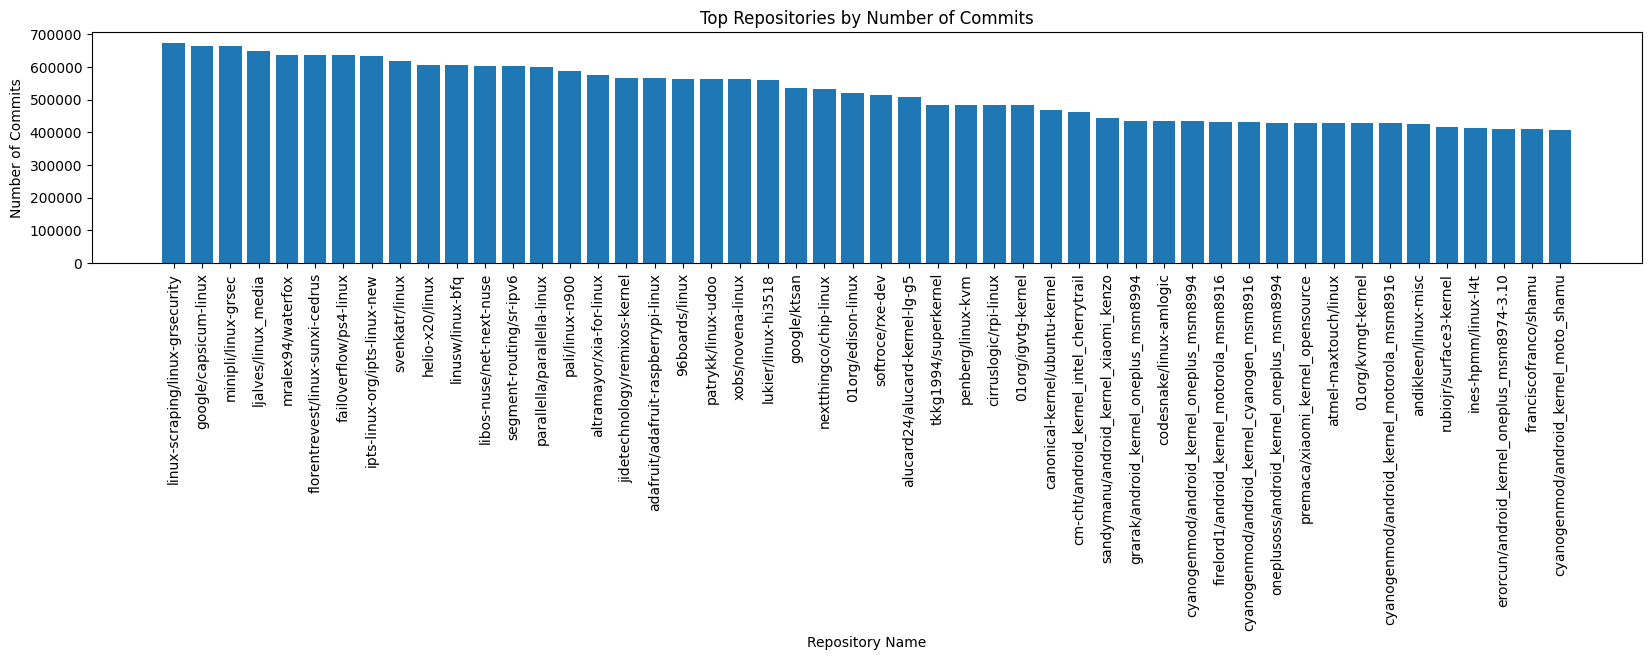

In [ ]:
# YOUR PLOT CODE HERE
client = bigquery.Client(project=project_id)

query = """
SELECT lrepo_name, COUNT(DISTINCT commit) as num_commits
FROM `cs145-fa19.project2.github_repo_commits`
GROUP BY lrepo_name
ORDER BY num_commits DESC
LIMIT 50
"""
results = client.query(query).to_dataframe()

plt.figure(figsize=(20, 3))
plt.bar(results['lrepo_name'], results['num_commits'])
plt.title("Top Repositories by Number of Commits")
plt.xlabel("Repository Name")
plt.ylabel("Number of Commits")
plt.xticks(rotation=90)
plt.show()